### Recursuve Feature Elimination

- Selecting important features using two main model (Lightgbm & Randomforest)
- Training the models using the selected features

#### Libraries

In [3]:
import pandas as pd


from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [141]:
df = pd.read_csv("data_with_IR.csv")

In [5]:
df.head(3)

,Date,Mean-value,Interest-rate,Month,Year,Quarter,Week-of-year,Week-of-month,Day-of-week,Day-of-year,election-year
0,10/11/2016,101.28,0.69,10.0,2016.0,4.0,42.0,3.0,2.0,285.0,0
1,10/13/2016,101.30,0.66,10.0,2016.0,4.0,42.0,3.0,4.0,287.0,0
2,10/13/2016,101.30,0.66,10.0,2016.0,4.0,42.0,3.0,4.0,287.0,0


In [6]:
X = df.drop(columns = ["Date", "Mean-value", "Year"], axis=1)
y = df["Mean-value"]

#### RECURSIVE FEATURE ELIMINATION

##### Lightgbm model

In [8]:
estimator = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
selector = RFE(estimator, n_features_to_select=5, step=1)
lgbm_rfe = selector.fit_transform(X, y)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 2078, number of used features: 8
[LightGBM] [Info] Start training from score 114.161442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [9]:
# Get the boolean mask of selected features
selected_mask = selector.support_

# If X is a DataFrame, get the names of the selected features
if hasattr(X, 'columns'):
    selected_features = X.columns[selected_mask]
else:
    # If X is a NumPy array, get the indices of selected features
    selected_features = [f"Feature_{i}" for i, selected in enumerate(selected_mask) if selected]

print("Selected Features:", selected_features)

Selected Features: Index(['Interest-rate', 'Month', 'Week-of-year', 'Day-of-year',
       'election-year'],
      dtype='object')


##### Random Forest Model

In [11]:
estimator = RandomForestRegressor()
rf_selector = RFE(estimator, n_features_to_select=5, step=1)
rf_rfe = rf_selector.fit_transform(X, y)

In [12]:
# Get the boolean mask of selected features
selected_mask = rf_selector.support_

# If X is a DataFrame, get the names of the selected features
if hasattr(X, 'columns'):
    selected_features = X.columns[selected_mask]
else:
    # If X is a NumPy array, get the indices of selected features
    selected_features = [f"Feature_{i}" for i, selected in enumerate(selected_mask) if selected]

print("Selected Features:", selected_features)

Selected Features: Index(['Interest-rate', 'Month', 'Week-of-year', 'Day-of-year',
       'election-year'],
      dtype='object')


In [13]:
X.head(3)

,Interest-rate,Month,Quarter,Week-of-year,Week-of-month,Day-of-week,Day-of-year,election-year
0,0.69,10.0,4.0,42.0,3.0,2.0,285.0,0
1,0.66,10.0,4.0,42.0,3.0,4.0,287.0,0
2,0.66,10.0,4.0,42.0,3.0,4.0,287.0,0


#### Training Random Forest & LightGBM Models using the selected features

In [15]:
X = df[['Interest-rate', 'Month', 'Week-of-year', 'Day-of-year',
       'election-year']]
y = df["Mean-value"]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=9)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1558, 5), (520, 5), (1558,), (520,))

In [49]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


### Ranking Features

In [73]:
from sklearn.inspection import permutation_importance
import shap
import numpy as np
import matplotlib.pyplot as plt

##### Lightgbm

In [19]:
lgbm = LGBMRegressor(n_estimators=100, learning_rate=1, max_depth=3)

In [ ]:
lgbm_model = lgbm.fit(X_train, y_train)

In [95]:
# Feature Importance from the model
importance_lgbm = pd.Series(lgbm_model.feature_importances_, index=X.columns)

In [97]:
# C. Permutation Feature Importance (Model-Agnostic)
result = permutation_importance(lgbm_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_permutation_lgbm = pd.Series(result.importances_mean, index=X.columns)


In [65]:
# D. SHAP Values
explainer = shap.Explainer(lgbm_model)  # Use the trained Random Forest
shap_values = explainer(X_test)

In [81]:
print("\nRanked Features (LightGBM):")
print(importance_lgbm.sort_values(ascending=False))


Ranked Features (Random Forest):
Interest-rate    273
Day-of-year      200
Week-of-year      66
Month             23
election-year      7
dtype: int32


In [21]:
lgbm_model.score(X_test, y_test)

0.8736484335851362

##### Random Forest

In [23]:
rf = RandomForestRegressor()

In [24]:
rf_model = rf.fit(X_train, y_train)

In [83]:
# Feature Importance from the model
importance_rf = pd.Series(rf_model.feature_importances_, index=X.columns)

In [85]:
# C. Permutation Feature Importance (Model-Agnostic)
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_permutation_rf = pd.Series(result.importances_mean, index=X.columns)

In [86]:
explainer = shap.Explainer(rf_model)  # Use the trained Random Forest
shap_values_rf = explainer(X_test)

In [87]:
print("\nRanked Features (Random Forest):")
print(importance_rf.sort_values(ascending=False))


Ranked Features (Random Forest):
Interest-rate    0.877823
Day-of-year      0.069147
election-year    0.024709
Week-of-year     0.019756
Month            0.008566
dtype: float64


In [25]:
rf_model.score(X_test, y_test)

0.8816493853687472

<Axes: title={'center': 'Random Forest Feature Importance'}>

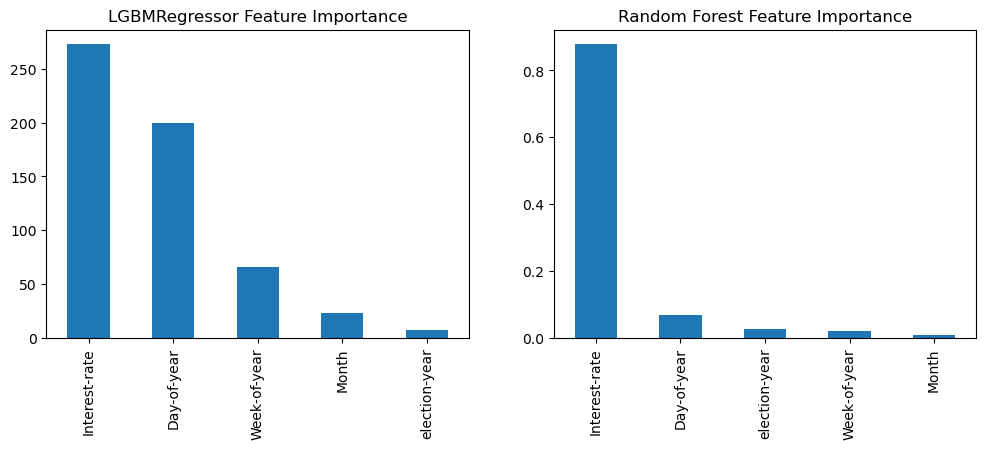

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))  # 2x2 grid of plots

# Plotting Random Forest Feature Importance
importance_lgbm.sort_values(ascending=False).plot(kind='bar', ax=axes[0], title='LGBMRegressor Feature Importance')

importance_rf.sort_values(ascending=False).plot(kind='bar',ax=axes[1], title='Random Forest Feature Importance')